In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utils.pipeline import data_cleaning

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train = pd.read_csv('../data/cs-training.csv').drop(['Unnamed: 0'], axis=1)
train = data_cleaning(train)
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## X-Y Split

In [3]:
X = train.drop(['SeriousDlqin2yrs'], axis=1)
y = train['SeriousDlqin2yrs']

- Train test split is not required as I will be using stratified k-fold spliting

## Parameter Search
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [4]:
# n_estimators Search

xg = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50,
                                max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)

params = { "n_estimators": [20, 30, 40, 50, 60, 70, 80]}


xg_grid = GridSearchCV(xg, param_grid=params, cv=5, 
                             scoring='roc_auc', verbose=2, 
                             n_jobs = -1)

xg_grid.fit(X, y)

results_table = pd.concat([pd.DataFrame(xg_grid.cv_results_["params"]),
                           pd.DataFrame(xg_grid.cv_results_["mean_test_score"], 
                                        columns=["AUC"])],axis=1).sort_values('AUC', ascending=False)

results_table.head(15)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:   49.7s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   53.7s finished


,n_estimators,AUC
5,70,0.865537
6,80,0.865528
4,60,0.865525
3,50,0.865493
2,40,0.865290
1,30,0.864739
0,20,0.864202


- Best estimator: 70

In [5]:
# max_depth and min_samples_split search

xg = GradientBoostingClassifier(learning_rate=0.1, min_samples_leaf=50,
                                max_features='sqrt',subsample=0.8, random_state=10,
                                n_estimators = 70)

params = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

xg_grid = GridSearchCV(xg, param_grid=params, cv=5, 
                             scoring='roc_auc', verbose=2, 
                             n_jobs = -1)

xg_grid.fit(X, y)

results_table = pd.concat([pd.DataFrame(xg_grid.cv_results_["params"]),
                           pd.DataFrame(xg_grid.cv_results_["mean_test_score"], 
                                        columns=["AUC"])],axis=1).sort_values('AUC', ascending=False)

results_table.head(15)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.1min finished


,max_depth,min_samples_split,AUC
7,7,600,0.865815
8,7,800,0.865717
9,7,1000,0.865629
5,7,200,0.865549
19,11,1000,0.865528
14,9,1000,0.865455
12,9,600,0.865438
13,9,800,0.865420
1,5,400,0.865307
6,7,400,0.865234


- best max_depth: 7
- best min_sample_split: 600

In [6]:
# min_samples_leaf

xg = GradientBoostingClassifier(learning_rate=0.1, 
                                random_state=10,
                                n_estimators = 70, max_depth =7, min_samples_split=600)

params = {'min_samples_leaf':range(30,71,10), 'max_features': ['sqrt', 'log2'],
         'subsample': [0.7, 0.8, 0.85]}

xg_grid = GridSearchCV(xg, param_grid=params, cv=5, 
                             scoring='roc_auc', verbose=2, 
                             n_jobs = -1)

xg_grid.fit(X, y)

results_table = pd.concat([pd.DataFrame(xg_grid.cv_results_["params"]),
                           pd.DataFrame(xg_grid.cv_results_["mean_test_score"], 
                                        columns=["AUC"])],axis=1).sort_values('AUC', ascending=False)

results_table.head(15)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.0min finished


,max_features,min_samples_leaf,subsample,AUC
22,log2,50,0.80,0.865815
7,sqrt,50,0.80,0.865815
29,log2,70,0.85,0.865716
14,sqrt,70,0.85,0.865716
24,log2,60,0.70,0.865708
9,sqrt,60,0.70,0.865708
20,log2,40,0.85,0.865682
5,sqrt,40,0.85,0.865682
2,sqrt,30,0.85,0.865663
17,log2,30,0.85,0.865663


- best max_feature: log2
- best min_samples_leaf: 50
- best subsample: 0.8

## Error Analysis

In [7]:
# decrease learning rate by half
xg = GradientBoostingClassifier(learning_rate=0.05, max_features='sqrt', random_state=10,
                                n_estimators = 70, max_depth =7, min_samples_split=600,
                                min_samples_leaf=50, subsample=0.8)

xg.fit(X, y)

GradientBoostingClassifier(learning_rate=0.05, max_depth=7, max_features='sqrt',
                           min_samples_leaf=50, min_samples_split=600,
                           n_estimators=70, random_state=10, subsample=0.8)

In [8]:
perm_importance = permutation_importance(xg, X, y)

Text(0.5, 0, 'Permutation Importance')

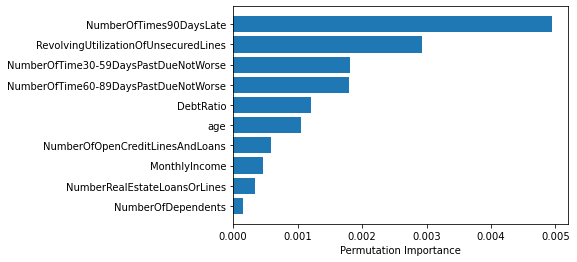

In [9]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

## Model Export 

In [10]:
filename = 'model/xg_boost.sav'
pickle.dump(xg, open(filename, 'wb'))

## Importing Model

In [11]:
loaded_model = pickle.load(open(filename, 'rb'))

## Inference

In [12]:
test = pd.read_csv('../data/cs-test.csv').drop(['Unnamed: 0'], axis=1)

In [13]:
test = data_cleaning(test, if_test = True)

In [14]:
test_pred = loaded_model.predict_proba(test)

In [15]:
results = pd.DataFrame(np.array(test_pred)[:,1:], columns=['Probability'])

In [16]:
results.index.name = 'id'
results.index = results.index+1
results.head()

,Probability
id,
1,0.074504
2,0.047320
3,0.015831
4,0.064114
5,0.106306


In [17]:
results.to_csv('output.csv')